In [24]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
%matplotlib inline
import astropy.constants as ac
import astropy.units as u

## Read in RV data for GJ 436 b

In [25]:
rv_data = astropy.io.ascii.read("UID_0057087_RVC_003.tbl.txt")

In [53]:
K = 18.34 * u.meter / u.second
K_0 = 28.4329 * u.meter / u.second
P = 2.64385 * u.day
e = 0.160 
Mtotal = 0.452 * u.Msun
a = 0.0285 * u.AU
# Msini (float): mass of planet [Mjup]
M_v1 = K / (K_0 * (a / (1 * u.AU))**(-0.5) * (Mtotal / (1 * u.Msun))**(-0.5) * (1 - e**2)**(-0.5))
Msini_v1 = M_v1 * u.Mjup
print(Msini_v1)
#M_v2 = K / (K_0 * (1 - e**2)**-0.5 * ((P / (1 * u.day))**(-1.0/3.0))**(-0.5)* (Mtotal / (1 * u.Msun))**(-0.5))
#Msini_v2 = M_v2 * u.Mjup
print(Msini_v2)
M_NASA = 0.0713 * u.Mjup
print((Msini_v1-M_NASA)/Msini_v1)
#print((Msini_v2-M_NASA))

0.07226673915638228 jupiterMass
0.5414695134759413 jupiterMass
0.01337737343164595


In [64]:
uncertainty = rv_data["Radial_Velocity_Uncertainty"].sum() / len(rv_data["Radial_Velocity_Uncertainty"])
aaa = uncertainty/rv_data["Radial_Velocity_Uncertainty"].sum()
print(uncertainty)
print(aaa)

2.2661016949152546
0.01694915254237288


# The Mpsini on the NASA website is 0.0713 +/- 0.006 

## Plot the best-fit model

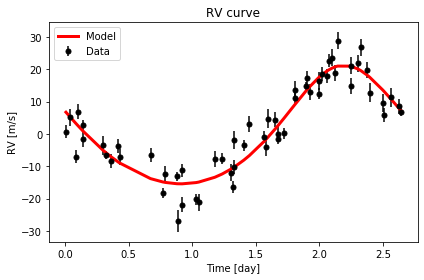

In [54]:
t = rv_data["JD"].data
import radvel
orbital_solution = [2.64385, 2451551.716, 0.160, 351 / 360.0 * 2 * np.pi, 18.34]
            #period, time at periastron, eccentricity, argument of periastron, RV semi-amplitude
rvs = radvel.kepler.rv_drive(t, orbital_solution, use_c_kepler_solver=False)
#print(351 / 360.0 * 2 * np.pi)
#print(rvs*1000)
#print(rv_data["Radial_Velocity"])

per = 2.64385

%matplotlib inline
# Fold data and plot model against data
ind = np.argsort(t % per)
plt.errorbar(t % per, rv_data["Radial_Velocity"], rv_data["Radial_Velocity_Uncertainty"], 
             color="black", ms=5, marker="o", ls="none", label="Data")
plt.plot((t % per)[ind], rvs[ind], "r-", label="Model", lw=3)
plt.legend()
plt.title("RV curve")
plt.xlabel("Time [day]")
plt.ylabel("RV [m/s]")
plt.tight_layout()
plt.savefig("RV curve.png")

## Fitting RV data for GJ 436 b

In [28]:
import scipy.signal as signal
x = rv_data["JD"]
y = rv_data["Radial_Velocity"]
e = rv_data["Radial_Velocity_Uncertainty"]

## Finding the periodicity in the data

In [29]:
nout = 1e5
f = np.linspace(0.01, 10.0, int(nout)) # frequency (1/day) at which power is calculated. 
#pgram = signal.lombscargle(x, y, f, normalize=True)
pgram = signal.lombscargle(x, y, f)

In [30]:
pgram

array([159.74876941, 174.43181967, 187.65462749, ...,  90.89880835,
        72.26694502,  56.60166339])

Text(0, 0.5, 'Power')

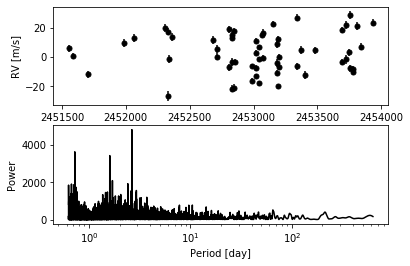

In [10]:
plt.subplot(2, 1, 1)
plt.errorbar(x, y , e, ms=5, marker="o", ls="none", color="black")
plt.xlabel("Time [JD]")
plt.ylabel("RV [m/s]")
plt.subplot(2, 1, 2)
plt.plot(2 * np.pi / f, pgram, color="black")
plt.xscale("log")
plt.xlabel("Period [day]")
plt.ylabel("Power")

In [11]:
print("The period with the highest power is: ", 2 * np.pi / f[np.where(pgram == np.max(pgram))][0], " day")

The period with the highest power is:  2.6439321027765184  day


The period is shown in the NASA website is 2.64385 +/- 0.00009 day

## Now gather information for orbital solution from references, we are ready for MCMC, which gives uncertainties for best-fit parameters.



## Define a model function with five parameters: 

## period (day), time at periastron (MJD), eccentricity, argument of periastron (degree), RV amplitude (m/s)

In [34]:
# def calcModel(params, t_stamp=None):
#     per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
#     rv = JW_lib.RadialVelocity([per, t0, ecc, omega, rv_amp])
#     return(rv.rv_drive(t_stamp))

def calcModel(params, t_stamp=None):
    per, t0, ecc, omega, rv_amp = params["per"], params["t0"], params["ecc"], params["omega"], params["K"]
    return(radvel.kepler.rv_drive(t_stamp, [per, t0, ecc, omega, rv_amp], use_c_kepler_solver=False))

## Define prior function 

In [38]:
def b_range(x, b):
    if x > b:
        return -np.inf
    else:
        return 0.

def a_b_range(x, a, b):
    if x < a:
        return -np.inf
    elif x > b:
        return -np.inf
    else:
        return 0.

def log_gaussian_prior(x, x0, std):
    return((-(x - x0)**2 / (2 * (std)**2)) / 2.3)




# define data and params that are fixed and variable
#planet_name = "HD 17156 b"
planet_name = "GJ 436 b"

if planet_name == "Teegarden b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 4.8, 5.0)
    log_priors['t0']           = lambda x: a_b_range(x, 2458090.603207, 2458092.603207)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.95)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 2*np.pi)
    log_priors['K']           = lambda x: a_b_range(x, 1., 5.)
    t_stamp      = rv_tg["col1"]
    data         = rv_tg["col2"]
    data_errors  = rv_tg["col3"]

    params = [4.910122, 2458091.603207, 0.222619, 82.339257 / 360 * 2 * np.pi,2.156248]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
elif planet_name == "GJ 436 b":
    log_priors = {}
    log_priors['per']           = lambda x: a_b_range(x, 2, 4)
    log_priors['t0']           = lambda x: a_b_range(x, 2451549.716, 2451552.716)
    log_priors['ecc']           = lambda x: a_b_range(x, 0., 0.32)
    log_priors['omega']       = lambda x: a_b_range(x, 0., 360.)
    log_priors['K']           = lambda x: a_b_range(x, 10., 50.)
    t_stamp      = rv_data["JD"]
    data         = rv_data["Radial_Velocity"]
    data_errors  = rv_data["Radial_Velocity_Uncertainty"]

    params = [2.64385, 2451551.716, 0.160, 351 / 360.0 * 2 * np.pi, 18.34]
    #[2.64385, 2451551.716, 0.160, 351 / 360.0 * 2 * np.pi, 18.34]
    params_keys = ["per", "t0", "ecc", "omega", "K"]
    params_fixed = []
    params_fixed_keys = []
else:
    print(""" Give me either "GJ 436 b" or "Teegarden b" """)


## Define likelihood function 

In [39]:
def calc_log_prob(params, data, data_errors, params_keys=params_keys, params_fixed=params_fixed, \
                  params_fixed_keys=params_fixed_keys, t_stamp=t_stamp, plot_flag=False):
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = params[i]

    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]

    # Prior calculation of all input parameters
    log_prior = 0.

    for key in params_keys:
        if not(type(params_dic[key]) is list):
            log_prior += log_priors[key](params_dic[key])
        else:
            for val in params_dic[key]:
                log_prior += log_priors[key](val)

    # Return -inf if parameters fall outside prior distribution
    if (log_prior == -np.inf):
        return -np.inf
    
    # Calculate the log-likelihood
    log_likelihood = 0.

    # Calculate the forward model, this
    # returns the wavelengths in um and flux in W/m2

    rv_model = calcModel(params_dic, t_stamp=t_stamp)

    if plot_flag:
        plt.plot(t_stamp, rv_model, "k^-", alpha=0.5, label="model")
        plt.plot(t_stamp, data, "rx-", alpha=0.5, label="data")
        plt.xlabel("Time [JD]")
        plt.ylabel("RV [m/s]")
        plt.legend()
        plt.show()

    # Just to make sure that a long chain does not die
    # unexpectedly:
    # Return -inf if forward model returns NaN values
    if np.sum(np.isnan(rv_model)) > 0:
        print("NaN spectrum encountered")
        return -np.inf

    # Calculate log-likelihood
    log_likelihood += -np.sum(((rv_model - data)/ \
                       data_errors)**2.)/2.

    if np.isnan(log_prior + log_likelihood):
        return -np.inf
    else:
        return log_prior + log_likelihood



## Test: calculate likelihood function

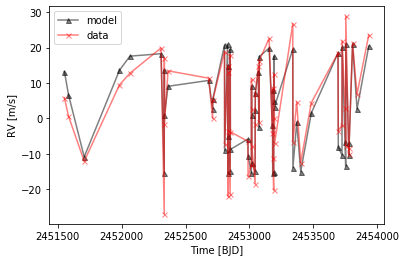

-121.97731778084156


In [40]:
print(calc_log_prob(params, data, data_errors, plot_flag=True))

## Now MCMC

In [41]:
import emcee

In [47]:
per = params[0]; e_per = 0.01
t0 = params[1]; e_t0 = 0.05
ecc = params[2]; e_ecc = 0.01
omega = params[3]; e_omega = 0.1
K = params[4]; e_K = 3.5


p_0 = params
e_p = [e_per, e_t0, e_ecc, e_omega, e_K]


ndim, nwalkers, nruns = len(p_0), 200, 1000
pos = [p_0 + e_p*np.random.randn(ndim) for i in range(nwalkers)]

import time as timer
start = timer.time()

from multiprocessing import Pool

# if pool works then use True, this option will use multi thread to increase computaional speed. Otherwise use False.
if False: 
    with Pool() as pool:

        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors), pool=pool, threads=5)
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))
else:
        # Initialize the sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_log_prob,
                                       args=(data, data_errors))
        sampler.run_mcmc(pos, 3000)


        #End timer
        end = timer.time()
        serial_time = end - start
        print("MCMC took {0:.1f} seconds".format(serial_time))    




MCMC took 471.1 seconds


## Check MCMC result

In [48]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))[0:-1:10, :]


print("flat chain shape: {0}".format(samples.shape))


flat chain shape: (40000, 5)


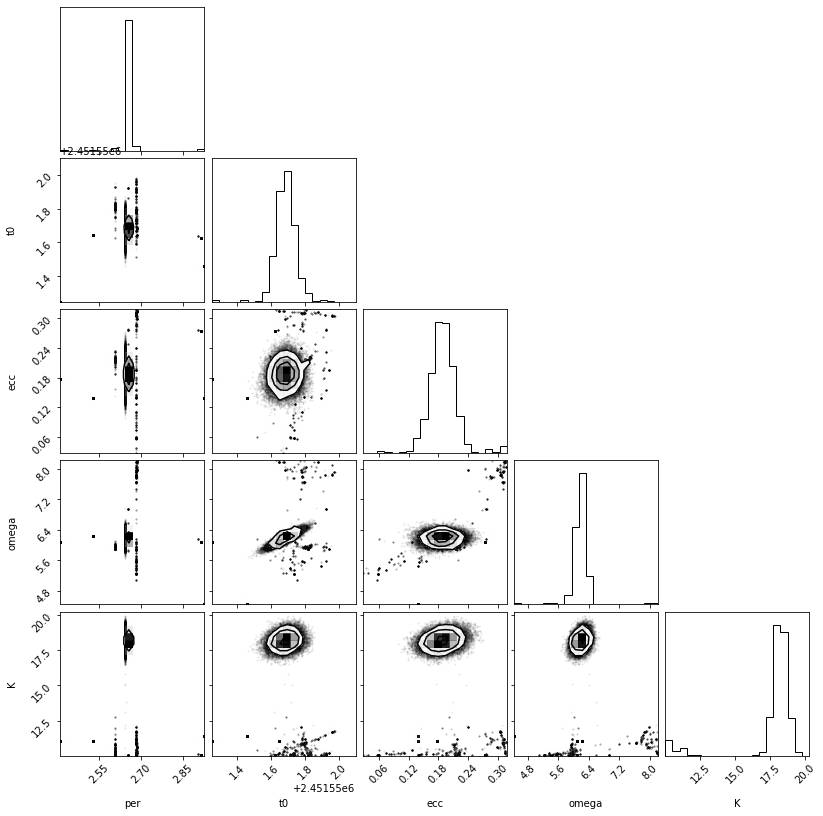

In [49]:
import corner
fig = corner.corner(samples, labels=params_keys, plot_contours=True)

## Plot models with data

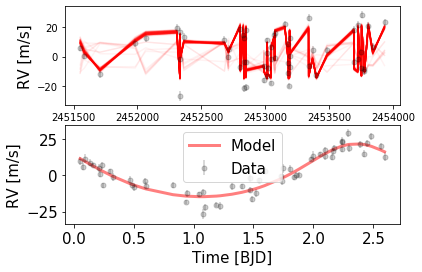

In [50]:
fig, ax = plt.subplots(2,1)

inds = np.random.randint(len(samples[:,0]), size=100)
for ind in inds:
    # Make dictionary 
    params_dic = {}
    for i, key in enumerate(params_keys):
        params_dic[key]       = samples[ind,:][i]        
    for i, key in enumerate(params_fixed_keys):
        params_dic[key]       = params_fixed[i]
    #print(params_dic["logg"])
    rv_model = calcModel(params_dic, t_stamp=t_stamp)
    ax[0].plot(t_stamp, rv_model, 'r', alpha=0.05,label='_nolegend_')
    
    
ax[0].errorbar(t_stamp, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[0].plot(t_stamp, rv_model, "r", alpha=0.5, label="Model")


# Getting median values
values = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
params = np.array(list(values))[:,0]
params_fixed = []
params_dic = {}
for i, key in enumerate(params_keys):
    params_dic[key]       = params[i]
for i, key in enumerate(params_fixed_keys):
    params_dic[key]       = params_fixed[i]


rv_model = calcModel(params_dic, t_stamp=t_stamp)
per = params_dic["per"]
ind1 = np.argsort(t_stamp % per)
ax[1].errorbar(t_stamp % per, data, data_errors, ms=5, marker="o", alpha=0.2, ls="none", color="black", label="Data")
ax[1].plot((t_stamp % per)[ind1], rv_model[ind1], "r", alpha=0.5,label='Model', lw=3)

ax[1].set_xlabel("Time [JD]", fontsize=15)
ax[0].set_ylabel("RV [m/s]", fontsize=15)
ax[1].set_ylabel("RV [m/s]", fontsize=15)

plt.gca().tick_params(labelsize=15)
ax[1].legend(fontsize=15)
# plt.tight_layout()
# plt.savefig("model_data.png")

In [51]:
#print(limb_darkening_coefficients)